In [66]:
from joblib import dump, load
!pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from sklearn import  metrics
from xgboost import XGBRegressor
from scipy.stats.distributions import uniform, randint

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
fname = "./drive/MyDrive/openpowerlifting.csv"
df = pd.read_csv(fname, parse_dates=True,low_memory=False)
df.head()

KeyboardInterrupt: ignored

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
#sprawdzamy ile % danego feature brakuje

lst = []
for cname in df.columns.tolist():
    percentage = round((100*df[cname].isna().sum()/df[cname].isna().count()), 2)
    lst.append((cname, percentage))

lst.sort(reverse=True, key = lambda x: x[1])

for element in lst:
    print(element[0] + ": " + str(element[1]) + "%")

In [ ]:
#pozbywamy sie wyników które chcemy przewidywać a także wszystkich innych featurów z których można wyliczyć squata
df = df.drop(["Squat1Kg", "Squat2Kg", "Squat3Kg", "TotalKg", "Place"], axis=1)
df = df.drop(["Wilks", "Glossbrenner", "IPFPoints", "McCulloch"], axis=1)
#usuwamy xxx4Kg bo występuje niezwykle rzadko 
#(jest to dodatkowe podejście przyznawane za jakiś błąd ze strony obsługi lub sędziów np. zawodnik miał założony zły ciężar)
df = df.drop(["Squat4Kg", "Deadlift4Kg", "Bench4Kg"], axis=1)
#ta sama informacja co Age i BodyWeightKg
df = df.drop(["AgeClass", "WeightClassKg"], axis=1)


In [ ]:
df.isna().any()

In [ ]:
print(df["Event"].value_counts())
df = df.drop(["Event","MeetName"], axis=1)
# możemy usunąc nazwę zawodów i event bo nie chcemy żeby wpływały na predykcję
print(df["Name"].value_counts())
df = df.drop("Name", axis=1)
#usuniemy też imiona zawodników pomimo tego, że będzie to sprzyjać zbliżeniu predykcji 
#do wyników zawodników, którzy startowali wiele razy (przy tak dużej ilości zawodników nie powinno to stworzyć dużej różnicy)

In [ ]:
# teraz pozbędziemy się wszystkich danych gdzie kluczowe feature są NaN 
# średnia byłaby tutaj słabym rozwiązaniem bo istnieje dużo zawodników startujących tylko dla jednego boju (szczególnie bench)
# i przynawanie im średniej byłoby dużym zawyżeniem ich prawdziwych wyników
columns = ["BodyweightKg", "Age", "Best3DeadliftKg", "Best3SquatKg", "Best3BenchKg"]

for col in columns:
    df = df.loc[(df[col].isna() == False) & (df[col] > 0)]

In [ ]:
print(df.isna().any())
# pozostałe NaN w 1,2,3Kg wynikają z niewykorzystanych podejść zawodników zastąpimy je danymi kategorycznymi
# jak łatwo się domyślić nie potrzeba tam dokładnych wyników bo ta sama informacja jest już w Best3Kg
# wystarczy nam informacja o ilości zaliczonych,spalonych i niewykorzystanych podejść
attemptCols = ["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]


def attemptTransformer(datapoint):
    if math.isnan(datapoint):
        return "Unknown"
    elif datapoint <= 0:
        return "Fail"
    else:
        return "Success"
    
for col in attemptCols:
    df[col] = df[col].apply(lambda x: attemptTransformer(x))
df.head()

In [ ]:
#Zostaje nam division, tested, country i MeetState
print(df["Tested"])
#w tested wystarczy zamienić NaN na informacje o tym że osoba nie była testowana np "No"
df["Tested"] = df["Tested"].fillna("No")

# w pozostałych przypadkach po prostu zamienimy je na missing value
from sklearn.impute import SimpleImputer

simpImputeCols = ["Country", "MeetState", "Division"]

simpImputer = SimpleImputer(strategy="constant")
df[simpImputeCols] = simpImputer.fit_transform(df[simpImputeCols])


In [ ]:
#Teraz nie mamy już żadnych NaN
print(df.isna().any())
df.index = np.arange(df.shape[0])

In [ ]:
#Oddzielamy features od przewidywanej wartości
X = df.drop("Best3SquatKg", axis=1)
y = df["Best3SquatKg"]

In [ ]:
# zobaczymy heatmape dla numerycznych features
numColumns = [col for col in X.columns.tolist() if X[col].dtype == "float64"]

sns.set(style="darkgrid")

corr = X[numColumns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr


In [ ]:
#sns.lineplot(x=X["Date"], y=y, linewidth=.1, estimator='mean')
# nie widać zależności wyników od czasu więc możemy pozbyć się daty zawodów

In [ ]:
catColumns = [col for col in X.columns.tolist() if X[col].dtype == "object"]
X = X.drop("Date", axis=1)
catColumns.remove("Date")
for col in catColumns:
    print(col + ": " + str(df[col].nunique()))


#Jak widac mamy kilka kategorycznych feature ktorych nie mozemy zonehotencodowac bo jest zbyt duzo unique values

In [ ]:
for name in catColumns:
    if X[name].nunique() < 15:
        sns.boxplot(x=X[name], y=y)
        plt.show()

In [ ]:
hotEncode = ["Sex", "Equipment", "Tested", "Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]

## one hot encoding
def oneHotEncode(X,hotEncode):  
    for col in hotEncode:
        X1 = pd.get_dummies(X[col], prefix=col)
        X = pd.concat([X, X1], axis=1)
        X= X.drop(col, axis=1)
    return (X)




In [ ]:
targetEncode = ["Division", "Country", "Federation", "MeetCountry", "MeetState"]

#target encoding dopiero po train test split
scaler =StandardScaler()
X[numColumns] = scaler.fit_transform(X[numColumns])


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

enc = TargetEncoder(cols=targetEncode, handle_missing="value", handle_unknown="value")

X_train = oneHotEncode(X_train,hotEncode)
X_train = enc.fit_transform(X_train, y_train)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) 

X_test = oneHotEncode(X_test,hotEncode)
X_val = oneHotEncode(X_val,hotEncode)

X_val = enc.transform(X_val)
X_test = enc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

#param_grid={"C": [0.001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000,1000000]} # wyszło że 1000 najlepsze
param_grid={"C": [100,500, 1000,5000, 10000]}                                   # wyszło 500
grid_LSVR = GridSearchCV(LinearSVR(), param_grid, cv=kfold, return_train_score=True,verbose=3)

grid_LSVR.fit(X_val, y_val)
grid_LSVR.best_params_

In [ ]:
param_distribution = {
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.001, 0.1-0.001),
    'n_estimators': randint(50, 400),
    'gamma': uniform(0,2),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 11)
}
random_XGB = RandomizedSearchCV(XGBRegressor(),param_distribution,n_jobs=-1,verbose=3)
random_XGB.fit(X_val,y_val)
print(random_XGB.best_params_)

In [ ]:
model_LSVR = LinearSVR(C=500,verbose=True)
model_LSVR.fit(X_train,y_train)

In [ ]:
model_XGB = XGBRegressor(colsample_bytree= 0.7263048317531272, gamma= 0.9562230244103234, learning_rate= 0.02960755053439744,
                         max_depth= 8, min_child_weight= 5, n_estimators= 378, subsample= 0.6318090352171479,verbose=True)
model_XGB.fit(X_train,y_train)

In [85]:
#dump(model_LSVR,'model_LSVR.joblib')
#dump(grid_LSVR,'grid_LSVR.joblib')
#dump(random_XGB,'random_XGB.joblib')
#dump(model_XGB,'model_XGB.joblib')
#model_XGB= load('model_XGB.joblib')
#random_XGB=load('random_XGB.joblib')
#grid_LSVR=load('grid_LSVR.joblib')
#model_LSVR=load('model_LSVR.joblib')

models = []


models.append(('grid_LSVR', grid_LSVR))
models.append(('model_LSVR', model_LSVR))
models.append(('model_XGB', model_XGB))
models.append(('random_XGB_', random_XGB.best_estimator_))


for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))

[15:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
grid_LSVR
R^2: 0.8554053047790862
Explained variance score: 0.904699887266828
Median absolute error: 18.416499754794586
Mean squared error: 755.667551048269
Mean absolute errors: 21.528959092274377
model_LSVR
R^2: 0.9024779781880093
Explained variance score: 0.9044844169196924
Median absolute error: 12.615928876661314
Mean squared error: 509.66065721395756
Mean absolute errors: 16.389702380477793
model_XGB
R^2: 0.9174904358893575
Explained variance score: 0.9174994884981496
Median absolute error: 11.423873901367188
Mean squared error: 431.20392594133847
Mean absolute errors: 14.980782743683626
random_XGB_
R^2: 0.9141262844678483
Explained variance score: 0.9141394972582497
Median absolute error: 11.57806396484375
Mean squared error: 448

In [ ]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(320, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(384, activation='relu'))
model.add(Dense(352, activation='relu'))
model.add(Dense(448, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='linear'))


model.summary()

model.compile(loss="mse", optimizer="adam")
          
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

In [87]:
model2 = Sequential()
model2.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(16, kernel_initializer='normal', activation='relu'))
model2.add(Dense(8, kernel_initializer='normal', activation='relu'))
model2.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

model2.compile(loss="mse", optimizer="adam")

In [88]:
history3 = model2.fit(X_train, y_train,
          batch_size=128, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100
2931/2931 [==============================] - 9s 3ms/step - loss: 2634.2920 - val_loss: 736.9785
Epoch 2/100
2931/2931 [==============================] - 8s 3ms/step - loss: 583.5494 - val_loss: 555.7725
Epoch 3/100
2931/2931 [==============================] - 9s 3ms/step - loss: 538.5488 - val_loss: 542.4641
Epoch 4/100
2931/2931 [==============================] - 8s 3ms/step - loss: 521.9713 - val_loss: 526.8196
Epoch 5/100
2931/2931 [==============================] - 8s 3ms/step - loss: 513.6966 - val_loss: 563.7309
Epoch 6/100
2931/2931 [==============================] - 8s 3ms/step - loss: 508.3304 - val_loss: 508.8589
Epoch 7/100
2931/2931 [==============================] - 8s 3ms/step - loss: 505.5398 - val_loss: 524.2785
Epoch 8/100
2931/2931 [==============================] - 8s 3ms/step - loss: 506.0231 - val_loss: 538.8638
Epoch 9/100
2931/2931 [==============================] - 8s 3ms/step - loss: 502.7773 - val_loss: 523.6360
Epoch 10/100
2931/2931 [============

INFO:tensorflow:Assets written to: keras_model_2/assets


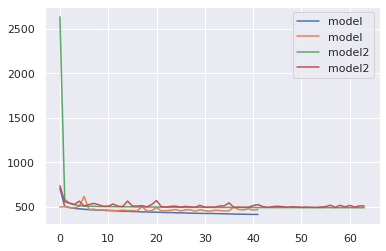

In [89]:
#model.save('keras_model_1')
#model2.save('keras_model_2')

plt.plot(pd.DataFrame(history.history),label="model")
plt.plot(pd.DataFrame(history3.history),label="model2")

plt.legend()
plt.grid(True)
plt.show()

In [90]:
models.append(('keras_model1', model))
models.append(('keras_model2', model2))



for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))

grid_LSVR
R^2: 0.8554053047790862
Explained variance score: 0.904699887266828
Median absolute error: 18.416499754794586
Mean squared error: 755.667551048269
Mean absolute errors: 21.528959092274377
model_LSVR
R^2: 0.9024779781880093
Explained variance score: 0.9044844169196924
Median absolute error: 12.615928876661314
Mean squared error: 509.66065721395756
Mean absolute errors: 16.389702380477793
model_XGB
R^2: 0.9174904358893575
Explained variance score: 0.9174994884981496
Median absolute error: 11.423873901367188
Mean squared error: 431.20392594133847
Mean absolute errors: 14.980782743683626
random_XGB_
R^2: 0.9141262844678483
Explained variance score: 0.9141394972582497
Median absolute error: 11.57806396484375
Mean squared error: 448.7853459385485
Mean absolute errors: 15.24790383422061
keras_model1
R^2: 0.9141262844678483
Explained variance score: 0.9141394972582497
Median absolute error: 11.57806396484375
Mean squared error: 448.7853459385485
Mean absolute errors: 15.2479038342206